In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
dirpath = "../dataset/"

data_files = ["cache/cache.csv", 
              "pools/ssd_random.csv", 
              "pools/ssd_sequential.csv", 
              "pools/hdd_sequential.csv"]

In [3]:
df = pd.read_csv(dirpath+data_files[0])
df.head(3)

,iops,lat,block_size,n_jobs,iodepth,read_fraction,load_type,io_type,raid,n_disks,device_type,offset,id
0,712511,386627.74,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769
1,709311,388112.33,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769
2,712464,386384.72,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769


In [4]:
def get_run(df, run_id, io_type='read'):
    io = df['io_type'].values.astype(str)
    ids = df['id'].values
    if io_type == 'read':
        sel = (io == 'read') | (io == '0')
    elif io_type == 'write':
        sel = (io == 'write') | (io == '1')
    sel = sel & (ids == run_id)
    return df[sel]

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

def remove_outliers(x, y, q=0.05):
    ee = EllipticEnvelope(contamination=q)
    # ee = IsolationForest(contamination=q)
    xy = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), axis=1)
    lab = ee.fit_predict(xy)
    # print(lab.sum()/len(lab))
    xy = xy[lab==1]
    return xy[:, 0], xy[:, 1]

In [5]:
def get_mu_sigma(afile):
    df = pd.read_csv(afile)
    ids = np.unique(df['id'].values)
    iops_mu = []
    iops_s = []
    lat_mu = []
    lat_s = []
    io_types = []
    for i in range(len(ids)):
        for io_type in ['read', 'write']:
            adf = get_run(df, ids[i], io_type=io_type)
            if len(adf) != 0:
                iops = adf['iops'].values
                lat = adf['lat'].values
                #iops, lat = remove_outliers(iops, lat)
                iops_mu.append(iops.mean())
                iops_s.append(iops.std())
                lat_mu.append(lat.mean())
                lat_s.append(lat.std())
                io_types.append(io_type)
    iops_mu = np.array(iops_mu)
    iops_s = np.array(iops_s)
    lat_mu = np.array(lat_mu)
    lat_s = np.array(lat_s)
    io_types = np.array(io_types)
    return iops_mu, iops_s, lat_mu, lat_s, io_types

cache/cache.csv


/var/folders/zn/n07tl_x16sg8f2l00mw2dyvr0000gn/T/ipykernel_56100/1978862129.py:44: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(3*10**-7, 0)


pools/ssd_random.csv


/var/folders/zn/n07tl_x16sg8f2l00mw2dyvr0000gn/T/ipykernel_56100/1978862129.py:44: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(3*10**-7, 0)


pools/ssd_sequential.csv


/var/folders/zn/n07tl_x16sg8f2l00mw2dyvr0000gn/T/ipykernel_56100/1978862129.py:44: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(3*10**-7, 0)


pools/hdd_sequential.csv


/var/folders/zn/n07tl_x16sg8f2l00mw2dyvr0000gn/T/ipykernel_56100/1978862129.py:44: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(3*10**-7, 0)


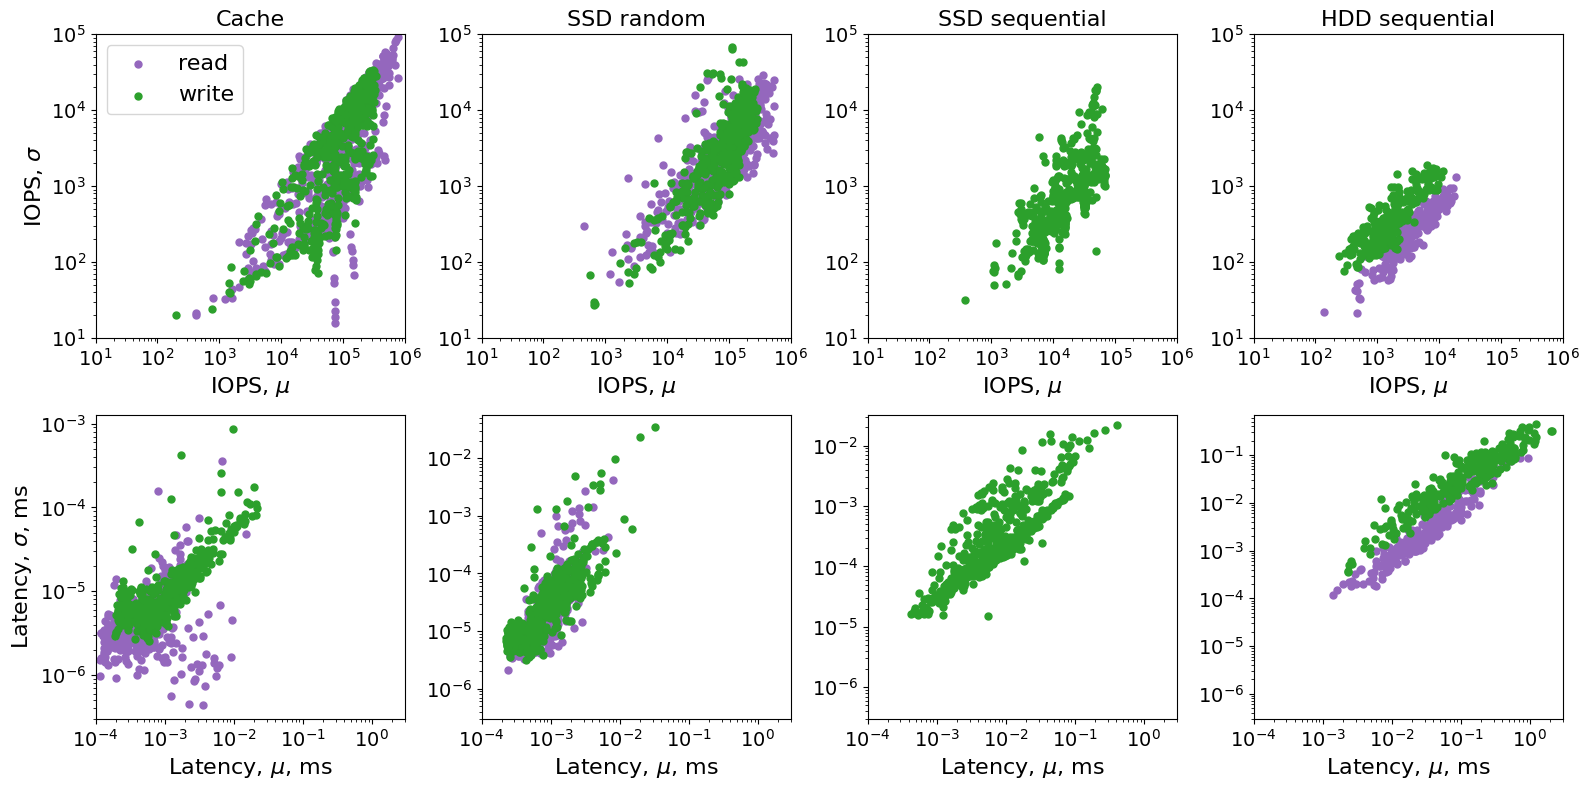

In [6]:
fig = plt.figure(figsize=(16, 8))

titles = ['Observations', 'kNN', 'CatBoost', 'NF']
labels = ['Cache', 'SSD random', 'SSD sequential', 'HDD sequential']


for i, afile in enumerate(data_files):
    print(afile)
    iops_mu, iops_s, lat_mu, lat_s, io_types = get_mu_sigma(dirpath+afile)

    plt.subplot(2, 4, i+1)
    plt.scatter(iops_mu[io_types=='read'], iops_s[io_types=='read'], color='C4', label='read', s=25)
    plt.scatter(iops_mu[io_types=='write'], iops_s[io_types=='write'], color='C2', label='write', s=25)
    #plt.plot([0, y_true.max()], [0, y_true.max()], color='0', linestyle='--')
    #plt.xlim(0, y_true.max())
    #plt.ylim(0, y_true.max())
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(10**1, 10**6)
    plt.ylim(10**1, 10**5)
    plt.xlabel(r"IOPS, $\mu$", size=16)
    if i == 0:
        plt.ylabel(r"IOPS, $\sigma$", size=16)
    #plt.grid(color='0.5')
    plt.title(labels[i], size=16)
    if i == 0:
        plt.legend(loc='best', fontsize=16)



    plt.subplot(2, 4, 4+i+1)
    plt.scatter(lat_mu[io_types=='read']/10**9, lat_s[io_types=='read']/10**9, color='C4', label='read', s=25)
    plt.scatter(lat_mu[io_types=='write']/10**9, lat_s[io_types=='write']/10**9, color='C2', label='write', s=25)
    #plt.plot([0, y_true.max()], [0, y_true.max()], color='0', linestyle='--')
    #plt.xlim(0, y_true.max())
    #plt.ylim(0, y_true.max())
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(10*10**-5, 3)
    plt.ylim(3*10**-7, 0)
    plt.xlabel(r"Latency, $\mu$, ms", size=16)
    if i == 0:
        plt.ylabel(r"Latency, $\sigma$, ms", size=16)
        
#fig.supxlabel(r"Queue depth $\times$ Number of jobs", size=16, y=0.)
#fig.supylabel(r"IOPS$_r$ $\times$ Latency$_r$ + IOPS$_w$ $\times$ Latency$_w$", size=16, x=0.)
plt.tight_layout()
plt.savefig("plots/iops_lat_mu_sigma.pdf", format='pdf')
plt.show()

In [7]:
plt.rcParams['lines.markersize'] ** 2

36.0